<a href="https://colab.research.google.com/github/hseghetto/Distribution-Gan/blob/main/04_Humberto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titulo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import pickle as pk
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from IPython.display import clear_output
import sklearn.neural_network as sknn

# Leitura e exploração dos dados

There are 39.92506244796004% of nominal cases


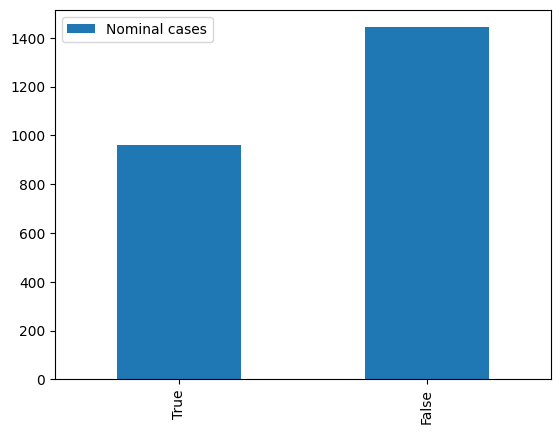

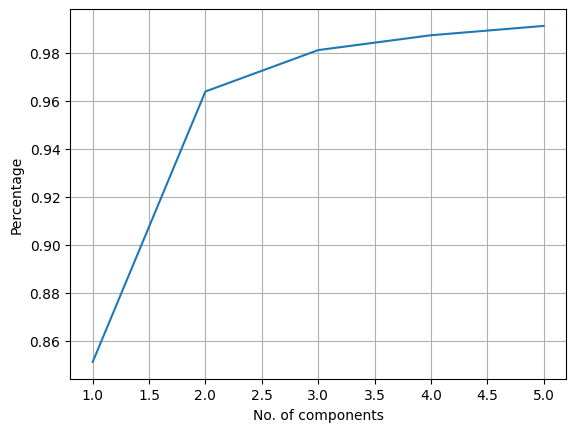

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/TCC/"
with open(path+"Tsdata.pickle", "rb") as fname:
    ([Xts]) = pk.load(fname)

with open(path+"alldata_info.pickle", "rb") as fname:
    (df2save) = pk.load(fname)

df2save['target'] = (df2save['case'] == 'A') | (df2save['case'] == 'B') | (df2save['case'] == 'C') | (df2save['case'] == 'R')
df2save['target'].value_counts().sort_values().plot(kind='bar')
plt.legend({'Nominal cases'})

print('There are ' + str(df2save['target'].sum()/len(df2save['target'])*100) + '% of nominal cases')

y = df2save['target']

pctExplVar = 0.99
pca = PCA(n_components=pctExplVar)
Xtsred = pca.fit_transform(Xts)

plt.figure()
plt.plot(np.arange(len(np.cumsum(pca.explained_variance_ratio_)))+1,np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.ylabel('Percentage')
plt.xlabel('No. of components')
plt.show()

In [ ]:
Xts.shape, Xtsred.shape

((2402, 48), (2402, 5))

In [ ]:
Xtsred[0:5,:]

array([[-5.53551908,  1.17782852,  0.2242756 , -0.15904104, -0.24356281],
       [-5.68152683,  1.0116827 ,  0.15158924, -0.10148506, -0.08661173],
       [-5.64041655,  0.8850916 ,  0.1326918 ,  0.03178893,  0.11990451],
       [-5.74539635,  1.20623889,  0.24005609, -0.17148133, -0.23251438],
       [-5.68920261,  1.07014931,  0.13065075, -0.13051693, -0.0616693 ]])

In [ ]:
def reject_outliers(data, m = 4.):
    data = data[:,0]
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev.all() else np.zeros(len(d))
    return s<m

map = reject_outliers(Xtsred)


Utilizando o PCA encontrei alguns casos bem claros de outliers. Removendo-os e comparando os resultados no desempenho observei que o metodo ridge melhorou significativamente, ficando comparavel aos outros sem necessitar de um parameter search. Entretanto o score médio continua menor que quando comprado ao caso sem PCA.

1) Por que o caso sem PCA não tem problemas com outliers

2) Por que o caso com PCA performa tão mal

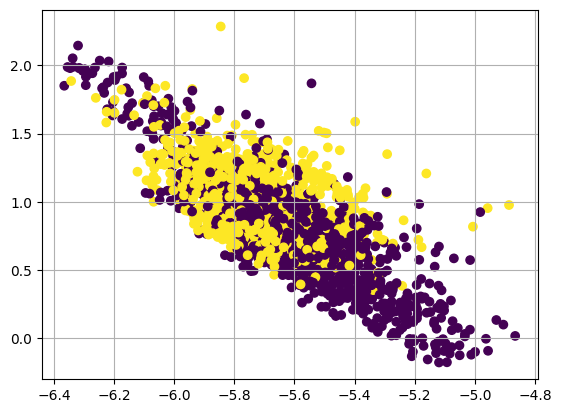

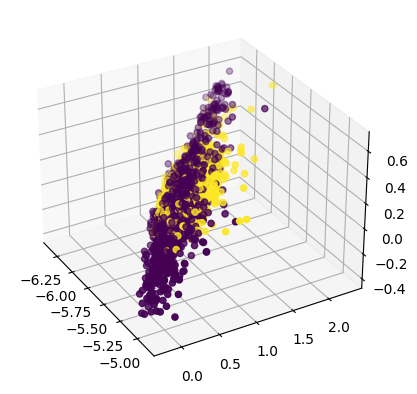

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Xtsred[map,0],Xtsred[map,1],c = y[map])
ax.grid()
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Xtsred[map,0],Xtsred[map,1],Xtsred[map,2],c = y[map])
ax.grid()

#Default = 30 -60 0
ax.view_init(30, -30, 0)
plt.show()


# Testing without PCA

In [ ]:
X0 = StandardScaler().fit_transform(X=Xts)

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y,test_size=0.4,random_state=0)

tree = DecisionTreeClassifier()
tree.fit(X0_train,y0_train)
y0tree = tree.predict(X0_test)

ridg = RidgeClassifier()
ridg.fit(X0_train,y0_train)
y0ridg = ridg.predict(X0_test)

svc = SVC()
svc.fit(X0_train,y0_train)
y0svc = svc.predict(X0_test)

print("Confusion matrix results:")
print(confusion_matrix(y0_test, y0tree))
print(confusion_matrix(y0_test, y0ridg))
print(confusion_matrix(y0_test, y0svc))
print()

print("Balanced accuracy")
print(metrics.balanced_accuracy_score(y0_test, y0tree))
print(metrics.balanced_accuracy_score(y0_test, y0ridg))
print(metrics.balanced_accuracy_score(y0_test, y0svc))
print()

print("F1 score")
print(metrics.f1_score(y0_test, y0tree))
print(metrics.f1_score(y0_test, y0ridg))
print(metrics.f1_score(y0_test, y0svc))
print()

print("Recall score")
print(metrics.recall_score(y0_test, y0tree))
print(metrics.recall_score(y0_test, y0ridg))
print(metrics.recall_score(y0_test, y0svc))

Confusion matrix results:
[[540  23]
 [ 21 377]]
[[553  10]
 [ 61 337]]
[[550  13]
 [ 76 322]]

Balanced accuracy
0.9531918027080339
0.9144858394994511
0.8929773199925024

F1 score
0.9448621553884713
0.9046979865771811
0.878581173260573

Recall score
0.9472361809045227
0.8467336683417085
0.8090452261306532


# Testing with PCA

In [ ]:
X = StandardScaler().fit_transform(X=Xtsred[map,:])

X_train, X_test, y_train, y_test = train_test_split(X, y[map],test_size=0.4,random_state=0)

tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
yhtree = tree.predict(X_test)

ridg = RidgeClassifier()
ridg.fit(X_train,y_train)
yhridg = ridg.predict(X_test)

svc = SVC()
svc.fit(X_train,y_train)
yhsvc = svc.predict(X_test)

print("Confusion matrix results:")
print(confusion_matrix(y_test, yhtree))
print(confusion_matrix(y_test, yhridg))
print(confusion_matrix(y_test, yhsvc))
print()

print("Balanced accuracy")
print(metrics.balanced_accuracy_score(y_test, yhtree))
print(metrics.balanced_accuracy_score(y_test, yhridg))
print(metrics.balanced_accuracy_score(y_test, yhsvc))
print()

print("F1 score")
print(metrics.f1_score(y_test, yhtree))
print(metrics.f1_score(y_test, yhridg))
print(metrics.f1_score(y_test, yhsvc))
print()

print("Recall score")
print(metrics.recall_score(y_test, yhtree))
print(metrics.recall_score(y_test, yhridg))
print(metrics.recall_score(y_test, yhsvc))

Confusion matrix results:
[[359 110]
 [ 79 260]]
[[398  71]
 [ 78 261]]
[[405  64]
 [ 61 278]]

Balanced accuracy
0.7662100370461221
0.8092627884597241
0.8417992213395726

F1 score
0.7334273624823696
0.7779433681073025
0.8164464023494861

Recall score
0.7669616519174042
0.7699115044247787
0.8200589970501475


# Parameter search:

In [ ]:
param_dist = {
    "criterion":["gini","entropy","log_loss"],
    "max_depth":[None,10,20,30],
    "max_leaf_nodes":[None,30,40,50,60,70],
    "max_features" :[None,2,3],
    "splitter":["best"]
}

tree = DecisionTreeClassifier()
rkf = RepeatedKFold(n_splits=5, n_repeats=10)
#tree_random_search = RandomizedSearchCV(tree, param_dist, random_state=0, n_iter = 100, verbose = 4, cv = 5)
tree_random_search = GridSearchCV(tree, param_dist, verbose = 4, cv = rkf)
tree_search_result = tree_random_search.fit(X_train, y_train)

clear_output()
print(tree_search_result.best_params_)

tree = DecisionTreeClassifier(**tree_search_result.best_params_)
tree.fit(X_train,y_train)
yytree = tree.predict(X_test)

print("tree results")
print("Optimized")
print(metrics.balanced_accuracy_score(y_test, yytree))
print(metrics.f1_score(y_test, yytree))
print(metrics.recall_score(y_test, yytree))

print("Unoptimezed")
print(metrics.balanced_accuracy_score(y_test, yhtree))
print(metrics.f1_score(y_test, yhtree))
print(metrics.recall_score(y_test, yhtree))

{'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 50, 'splitter': 'best'}
tree results
Optimized
0.8443482956523292
0.8176100628930818
0.8165829145728644
Unoptimezed
0.83081035729268
0.8019925280199252
0.8090452261306532


In [ ]:
param_dist = {
    "alpha": sp_randFloat(0,2),
    "class_weight":["balanced",None],
    "solver":["svd","cholesky","lsqr","sparse_cg","sag","saga","lbfgs"]
}

ridg = RidgeClassifier()
rkf = RepeatedKFold(n_splits=5, n_repeats=5)
ridg_random_search = RandomizedSearchCV(ridg, param_dist, random_state=0, n_iter = 100, verbose = 4, cv = rkf)
ridg_search_result = ridg_random_search.fit(X_train, y_train)

clear_output()
print(ridg_search_result.best_params_)

ridg = RidgeClassifier(**ridg_search_result.best_params_)
ridg.fit(X_train,y_train)
yyridg = ridg.predict(X_test)

print("ridg results")
print("Optimized")
print(metrics.balanced_accuracy_score(y_test, yyridg))
print(metrics.f1_score(y_test, yyridg))
print(metrics.recall_score(y_test, yyridg))

print("Unoptimezed")
print(metrics.balanced_accuracy_score(y_test, yhridg))
print(metrics.f1_score(y_test, yhridg))
print(metrics.recall_score(y_test, yhridg))

{'alpha': 0.5950692130889446, 'class_weight': 'balanced', 'solver': 'svd'}
ridg results
Optimized
0.7057846961271723
0.6719636776390465
0.7437185929648241
Unoptimezed
0.9144858394994511
0.9046979865771811
0.8467336683417085


In [ ]:
param_dist = {
    "kernel":['linear','poly', 'rbf', 'sigmoid'],
    "gamma":["auto","scale"],
    "coef0":sp_randFloat(-1,1),
    "degree":sp_randInt(2,6)
}

svc = SVC()
rkf = RepeatedKFold(n_splits=5, n_repeats=5)
svc_random_search = RandomizedSearchCV(svc, param_dist, random_state=0, n_iter = 100, verbose = 4, cv = rkf)
svc_search_result = svc_random_search.fit(X_train, y_train)

clear_output()
print(svc_search_result.best_params_)

svc = SVC(**svc_search_result.best_params_)
svc.fit(X_train,y_train)
yysvc = svc.predict(X_test)

print("SVC results")
print("Optimized")
print(metrics.balanced_accuracy_score(y_test, yysvc))
print(metrics.f1_score(y_test, yysvc))
print(metrics.recall_score(y_test, yysvc))

print("Unoptimezed")
print(metrics.balanced_accuracy_score(y_test, yhsvc))
print(metrics.f1_score(y_test, yhsvc))
print(metrics.recall_score(y_test, yhsvc))

{'coef0': -0.07884238976280022, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
SVC results
Optimized
0.8068986138507814
0.7698519515477792
0.7185929648241206
Unoptimezed
0.8009853887555004
0.7621621621621621
0.7085427135678392
